In [1]:
# import libraries
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

### Load and Explore the data

In [2]:
# load data
df = pd.read_csv("../data/raw/PIOP2_restingstate.csv")

# print shape of data
print("Data shape:", df.shape)

Data shape: (224, 26797)


### Extract and Explore Brain Region Names

In [3]:
# get list of column names 
connection_columns = list(df.columns[1:])
for i in range(10):
    print(f"Column {i}: {connection_columns[i]}")

Column 0: LH_VisCent_ExStr_2~LH_VisCent_ExStr_1
Column 1: LH_VisCent_Striate_1~LH_VisCent_ExStr_1
Column 2: LH_VisCent_Striate_1~LH_VisCent_ExStr_2
Column 3: LH_VisCent_ExStr_3~LH_VisCent_ExStr_1
Column 4: LH_VisCent_ExStr_3~LH_VisCent_ExStr_2
Column 5: LH_VisCent_ExStr_3~LH_VisCent_Striate_1
Column 6: LH_VisCent_ExStr_4~LH_VisCent_ExStr_1
Column 7: LH_VisCent_ExStr_4~LH_VisCent_ExStr_2
Column 8: LH_VisCent_ExStr_4~LH_VisCent_Striate_1
Column 9: LH_VisCent_ExStr_4~LH_VisCent_ExStr_3


In [4]:

# Output first few rows of the dataframe
df.iloc[:5, :10]

,subject,LH_VisCent_ExStr_2~LH_VisCent_ExStr_1,LH_VisCent_Striate_1~LH_VisCent_ExStr_1,LH_VisCent_Striate_1~LH_VisCent_ExStr_2,LH_VisCent_ExStr_3~LH_VisCent_ExStr_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_2,LH_VisCent_ExStr_3~LH_VisCent_Striate_1,LH_VisCent_ExStr_4~LH_VisCent_ExStr_1,LH_VisCent_ExStr_4~LH_VisCent_ExStr_2,LH_VisCent_ExStr_4~LH_VisCent_Striate_1
0,sub-0001_P2,0.449238,0.730071,0.524210,0.497770,0.276710,0.561038,0.535327,0.320928,0.321861
1,sub-0002_P2,0.393719,0.395647,0.202585,0.398541,0.500504,0.524234,0.700316,0.486421,0.298096
2,sub-0003_P2,0.450831,0.626590,0.278283,0.797884,0.578479,0.717570,0.780219,0.487029,0.415442
3,sub-0004_P2,0.114870,0.699719,0.194956,0.472048,0.319263,0.670253,0.641608,-0.066746,0.583233
4,sub-0005_P2,0.292478,0.295879,0.569524,0.132842,0.588398,0.412301,0.765964,0.344644,0.403666


In [5]:
# Step 2: Extract region names from column names
conn_columns = df.columns[1:]  # Exclude subject ID column
print("\n Number of connection columns:", len(conn_columns))

# split each column name by '~' and get unique region names
region_pairs = [col.split('~') for col in conn_columns]
print("\n First 5 region pairs:", region_pairs[:5])

# Flatten the list of region names while preservinf order
region_list = []
for pair in region_pairs:
    for region in pair:
        if region not in region_list:
            region_list.append(region)

print("\n Number of unique regions:", len(region_list))
print("\n First 10 unique regions:", region_list[:10])


 Number of connection columns: 26796

 First 5 region pairs: [['LH_VisCent_ExStr_2', 'LH_VisCent_ExStr_1'], ['LH_VisCent_Striate_1', 'LH_VisCent_ExStr_1'], ['LH_VisCent_Striate_1', 'LH_VisCent_ExStr_2'], ['LH_VisCent_ExStr_3', 'LH_VisCent_ExStr_1'], ['LH_VisCent_ExStr_3', 'LH_VisCent_ExStr_2']]

 Number of unique regions: 232

 First 10 unique regions: ['LH_VisCent_ExStr_2', 'LH_VisCent_ExStr_1', 'LH_VisCent_Striate_1', 'LH_VisCent_ExStr_3', 'LH_VisCent_ExStr_4', 'LH_VisCent_ExStr_5', 'LH_VisPeri_ExStrInf_1', 'LH_VisPeri_ExStrInf_2', 'LH_VisPeri_ExStrInf_3', 'LH_VisPeri_StriCal_1']


### Reconstruct Connectivity Matrix and Create Dataset

In [6]:
# Step 3 : Create a new dataframe structure 

# Intialize a list to collect all subject-region combination
reshaped_rows = []

# Loop through each subject
for index, row in df.iterrows():
    subject_id = row['subject']
    
    # Loop through each unique region
    for region in region_list:
        reshaped_rows.append([subject_id, region])

# Create a DataFrame with 'subject' and 'RegionNames'
df_out = pd.DataFrame(reshaped_rows, columns=['subject', 'RegionNames'])

print("Reshaped DataFrame shape:", df_out.shape) 

Reshaped DataFrame shape: (51968, 2)


In [7]:
# Step 4: Add columns of all regions
for region in region_list:
    df_out[region] = None  # initialize columns

print("\nAdded all region columns. Total columns now:", len(df_out.columns))


Added all region columns. Total columns now: 234


In [9]:
# Step 5: Fill in values 
for col in conn_columns:
    r1,r2 = col.split('~')
    
    # skip if regions are the same
    if r1 == r2:
        continue
    # For each subject, fill the connectivity value symmetrically
    for i, subject in enumerate(df['subject']):
        value = df.loc[i, col]
        
        # Fill cells [subject, r1, r2] and [subject, r2, r1]    
        df_out.loc[(df_out['subject'] == subject) & (df_out['RegionNames'] == r1), r2] = value
        df_out.loc[(df_out['subject'] == subject) & (df_out['RegionNames'] == r2), r1] = value  

print("\nFilled connectivity values. Sample data:")
df_out.iloc[:10, :10]

KeyboardInterrupt: 

In [ ]:
# Step 6: Inspect the final dataframe
print("\nFinal DataFrame shape:", df_out.shape)


### Subject wise 5 fold cross validation

In [ ]:

# find all unique subject IDs
unique_subjects = np.unique(subjects)
n_subjects = len(unique_subjects)
print("Number of unique subjects:", n_subjects)

# we will use 5 folds for cross-validation
kf_subjects = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# since each subject has all regions, we create a dummy array for stratification
subject_dummy = np.zeros(n_subjects)

# lists to store accuracy results for each fold
fold_accuracies = []
fold_balanced_accuracies = []

# lists to collect all true and predicted labels
all_y_true = []
all_y_pred = []

print("\nTraining Multi-Class Logistic Regression...")

# loop over each fold
fold_idx = 1
for train_subject_idx, val_subject_idx in kf_subjects.split(unique_subjects, subject_dummy):
    print("\n===========================================")
    print("Fold", fold_idx)
    print("===========================================")
    
    # get subject IDs for training and validation
    train_subjects = unique_subjects[train_subject_idx]
    val_subjects = unique_subjects[val_subject_idx]
    
    # get the corresponding sample indices from the main dataset
    train_mask = np.isin(subjects, train_subjects)
    val_mask = np.isin(subjects, val_subjects)
    
    X_train = X[train_mask]
    X_val = X[val_mask]
    y_train = y[train_mask]
    y_val = y[val_mask]
    
    print("Train subjects:", len(train_subjects), "| Samples:", X_train.shape[0])
    print("Val subjects:", len(val_subjects), "| Samples:", X_val.shape[0])
    
    # standardize the features (important for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # create the logistic regression model
    model = LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        n_jobs=-1,
        C=0.2  # smaller C = stronger regularization
    )
    
    # train the model
    model.fit(X_train_scaled, y_train)
    
    # make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    # calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
    
    # store results
    fold_accuracies.append(val_acc)
    fold_balanced_accuracies.append(val_balanced_acc)
    
    print("\nResults for this fold:")
    print("  Training Accuracy:", round(train_acc, 4))
    print("  Validation Accuracy:", round(val_acc, 4))
    print("  Validation Balanced Accuracy:", round(val_balanced_acc, 4))
    
    # collect predictions for overall results
    all_y_true.extend(y_val)
    all_y_pred.extend(y_val_pred)
    
    fold_idx += 1

Number of unique subjects: 224

Training Multi-Class Logistic Regression...

Fold 1
Train subjects: 149 | Samples: 34568
Val subjects: 75 | Samples: 17400

Results for this fold:
  Training Accuracy: 0.9667
  Validation Accuracy: 0.7148
  Validation Balanced Accuracy: 0.7148

Fold 2
Train subjects: 149 | Samples: 34568
Val subjects: 75 | Samples: 17400

Results for this fold:
  Training Accuracy: 0.9657
  Validation Accuracy: 0.7186
  Validation Balanced Accuracy: 0.7186

Fold 3
Train subjects: 150 | Samples: 34800
Val subjects: 74 | Samples: 17168

Results for this fold:
  Training Accuracy: 0.9657
  Validation Accuracy: 0.7158
  Validation Balanced Accuracy: 0.7158


### Overall Performance Evaluation

In [11]:
# Performance Evaluation
print("\nCross-Validation Summary")
print("-" * 60)

mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
mean_bal_acc = np.mean(fold_balanced_accuracies)
std_bal_acc = np.std(fold_balanced_accuracies)
min_acc = np.min(fold_accuracies)
max_acc = np.max(fold_accuracies)

print("Mean Validation Accuracy:", round(mean_acc, 4), "±", round(std_acc, 4))
print("Mean Balanced Accuracy:", round(mean_bal_acc, 4), "±", round(std_bal_acc, 4))
print("Min/Max Accuracy:", "[", round(min_acc, 4), ",", round(max_acc, 4), "]")

# baseline accuracy (random guess)
baseline_acc = 1.0 / n_regions
improvement = mean_acc / baseline_acc

print("Baseline (random):", round(baseline_acc, 4))
print("Improvement over baseline:", round(improvement, 2), "x")

# ===== Classification report =====
print("\n" + "="*70)
print("Classification Report (Sample of up to 20 regions)")
print("="*70)

unique_classes = sorted(list(set(all_y_true)))

# take only 20 regions if there are many
if len(unique_classes) > 20:
    sample_classes = unique_classes[:20]
else:
    sample_classes = unique_classes

# print detailed classification metrics
report = classification_report(
    all_y_true,
    all_y_pred,
    labels=sample_classes,
    target_names=[region_list[i] for i in sample_classes],
    digits=4,
    zero_division=0
)

print(report)

# ===== Confusion matrix and per-region accuracy =====
print("\n" + "="*70)
print("Per-Region Classification Performance")
print("="*70)

cm = confusion_matrix(all_y_true, all_y_pred)
per_region_accuracy = np.diag(cm) / cm.sum(axis=1)

print("\nStatistics across", n_regions, "regions:")
print("Mean Accuracy:", round(np.nanmean(per_region_accuracy), 4))
print("Median Accuracy:", round(np.nanmedian(per_region_accuracy), 4))
print("Std Accuracy:", round(np.nanstd(per_region_accuracy), 4))
print("Min Accuracy:", round(np.nanmin(per_region_accuracy), 4))
print("Max Accuracy:", round(np.nanmax(per_region_accuracy), 4))

# ===== Top and bottom performing regions =====
print("\nTop 10 Best Classified Regions:")
best_idx = np.argsort(per_region_accuracy)[-10:][::-1]
for rank, idx in enumerate(best_idx, 1):
    if not np.isnan(per_region_accuracy[idx]):
        print(rank, ".", region_list[idx], ":", round(per_region_accuracy[idx], 4))

print("\nTop 10 Worst Classified Regions:")
worst_idx = np.argsort(per_region_accuracy)[:10]
for rank, idx in enumerate(worst_idx, 1):
    if not np.isnan(per_region_accuracy[idx]):
        print(rank, ".", region_list[idx], ":", round(per_region_accuracy[idx], 4))


Cross-Validation Summary
------------------------------------------------------------
Mean Validation Accuracy: 0.7164 ± 0.0016
Mean Balanced Accuracy: 0.7164 ± 0.0016
Min/Max Accuracy: [ 0.7148 , 0.7186 ]
Baseline (random): 0.0043
Improvement over baseline: 166.2 x

Classification Report (Sample of up to 20 regions)
                    precision    recall  f1-score   support

  LH_ContA_Cingm_1     0.9227    0.8527    0.8863       224
    LH_ContA_IPS_1     0.7253    0.7545    0.7396       224
    LH_ContA_IPS_2     0.6400    0.6429    0.6414       224
    LH_ContA_IPS_3     0.6512    0.6250    0.6378       224
   LH_ContA_PFCd_1     0.8826    0.8393    0.8604       224
   LH_ContA_PFCl_1     0.5947    0.6027    0.5987       224
   LH_ContA_PFCl_2     0.6290    0.6205    0.6247       224
   LH_ContA_PFCl_3     0.6256    0.5893    0.6069       224
  LH_ContA_PFClv_1     0.7656    0.7143    0.7390       224
   LH_ContA_Temp_1     0.7543    0.7812    0.7675       224
    LH_ContB_IPL_1 

### Visualization


Generating Visualizations...
✓ Saved figure as 'region_classification_results.png'

ANALYSIS COMPLETE!

Key Findings:
- Classified 232 brain regions based on connectivity patterns
- Overall accuracy: 71.64 %
- 166.2 times better than random guessing
- 221 / 232 regions showed >50% accuracy


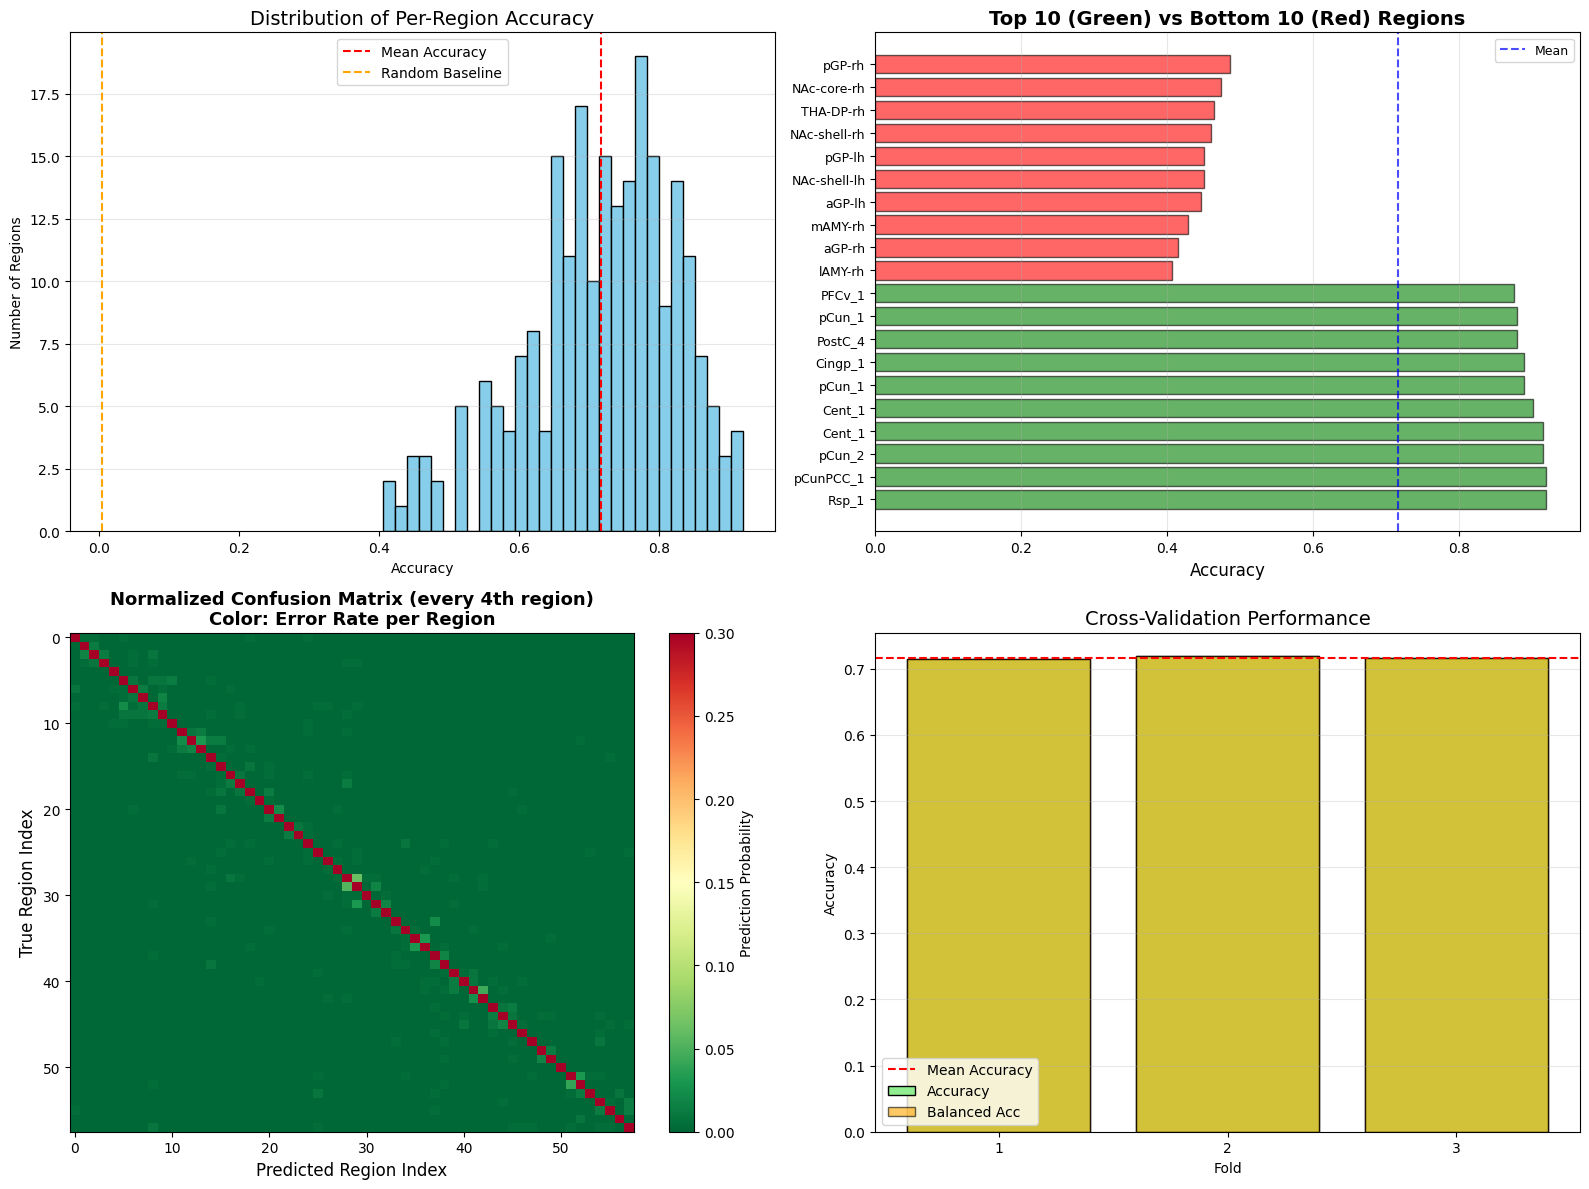

In [ ]:
print("Generating Visualizations...")

# create figure with 4 subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribution of per-region accuracy

valid_accs = per_region_accuracy[~np.isnan(per_region_accuracy)]

axes[0, 0].hist(valid_accs, bins=30, color='skyblue', edgecolor='black')
axes[0, 0].axvline(np.nanmean(per_region_accuracy), color='red', linestyle='--', label='Mean Accuracy')
axes[0, 0].axvline(baseline_acc, color='orange', linestyle='--', label='Random Baseline')
axes[0, 0].set_title('Distribution of Per-Region Accuracy', fontsize=14)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Number of Regions')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)


# Plot 2: Top/Bottom regions
top_10 = np.argsort(per_region_accuracy)[-10:][::-1]  # Reverse for top-down display
bottom_10 = np.argsort(per_region_accuracy)[:10]
comparison_idx = np.concatenate([top_10, bottom_10])
comparison_accs = per_region_accuracy[comparison_idx]

# Create better labels - extract meaningful part of region name
comparison_labels = []
for i in comparison_idx:
    full_name = region_list[i]
    # Try to get a meaningful abbreviated name
    # Remove hemisphere prefix and take last meaningful parts
    parts = full_name.replace('LH_', '').replace('RH_', '').split('_')
    if len(parts) >= 2:
        label = '_'.join(parts[-2:])[:25]  # Last two parts, max 25 chars
    else:
        label = full_name[:25]
    comparison_labels.append(label)

colors = ['green']*10 + ['red']*10
axes[0, 1].barh(range(20), comparison_accs, color=colors, alpha=0.6, edgecolor='black')
axes[0, 1].set_yticks(range(20))
axes[0, 1].set_yticklabels(comparison_labels, fontsize=9)
axes[0, 1].set_xlabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Top 10 (Green) vs Bottom 10 (Red) Regions', fontsize=14, fontweight='bold')
axes[0, 1].axvline(np.nanmean(per_region_accuracy), color='blue', linestyle='--', 
                   alpha=0.7, label='Mean')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Normalized confusion matrix (shows misclassification patterns)
# Normalize by row to show prediction distribution for each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Sample regions for visualization
step = max(1, n_regions // 50)
cm_norm_subset = cm_normalized[::step, ::step]

# Replace NaN with 0
cm_norm_subset = np.nan_to_num(cm_norm_subset)

im = axes[1, 0].imshow(cm_norm_subset, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=0.3)
axes[1, 0].set_xlabel('Predicted Region Index', fontsize=12)
axes[1, 0].set_ylabel('True Region Index', fontsize=12)
axes[1, 0].set_title(f'Normalized Confusion Matrix (every {step}th region)\nColor: Error Rate per Region', 
                     fontsize=13, fontweight='bold')
cbar = plt.colorbar(im, ax=axes[1, 0])
cbar.set_label('Prediction Probability', fontsize=10)

# Plot 4: Accuracy by fold
n_folds = len(fold_accuracies)

axes[1, 1].bar(range(1, n_folds + 1), fold_accuracies, color='lightgreen', edgecolor='black', label='Accuracy')
axes[1, 1].bar(range(1, n_folds + 1), fold_balanced_accuracies, 
               alpha=0.6, color='orange', edgecolor='black', label='Balanced Acc')
axes[1, 1].axhline(np.mean(fold_accuracies), color='red', linestyle='--', label='Mean Accuracy')
axes[1, 1].set_title('Cross-Validation Performance', fontsize=14)
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_xticks(range(1, n_folds + 1))
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

# adjust spacing and save figure
plt.tight_layout()
plt.savefig('region_classification_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved figure as 'region_classification_results.png'")

# Final Summary
print("ANALYSIS COMPLETE!")


overall_acc = np.mean(fold_accuracies)
improvement_factor = overall_acc / baseline_acc
distinctive_regions = (per_region_accuracy > 0.5).sum()

print("\nKey Findings:")
print("- Classified", n_regions, "brain regions based on connectivity patterns")
print("- Overall accuracy:", round(overall_acc * 100, 2), "%")
print("-", round(improvement_factor, 1), "times better than random guessing")
print("-", distinctive_regions, "/", n_regions, "regions showed >50% accuracy")

In [14]:
# save the standarscaler and logistic regression model 
import pickle
import os

# creat dir model to save the models
if not os.path.exists('model'):
    os.makedirs('model')

# save the scaler
with open('../model/scaler_nb.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# save the model
with open('../model/model_nb.pkl', 'wb') as f:
    pickle.dump(model, f)
